In [78]:
!pip install xgboost

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime as dt
import json

##############################################################################################################################
# 1) Baseline Model (Unchanged in logic) but keep in mind: it returns proba[:,1] as "pass"
##############################################################################################################################



def check_band_gap(wafer_no, bias_value):
    """
    Replicates the original logic:
    If wafer_no == 9:
        - if bias_value < 1.21492 -> 'bandGapFail'
        - else                   -> 'ok for band gap'
    If wafer_no == 10:
        - if bias_value < 1.2045 -> 'bandGapFail'
        - else                  -> 'ok for band gap'
    Else:
        - 'impossible Wafer'
    """
    if wafer_no == 9:
        if bias_value < 1.21492:
            return False
        else:
            return True
    elif wafer_no == 10:
        if bias_value < 1.2045:
            return False
        else:
            return True
    else:
        return False

class BaselineModel:
    def __init__(self):
        self.radius = 70
        self.sensor_offset_hot_cold = 0.02
        pass

    def check_band_gap(self, wafer_no, bias_value):
        if wafer_no == 9:
            if bias_value < 1.21492:
                return False
            else:
                return True
        elif wafer_no == 10:
            if bias_value < 1.2045:
                return False
            else:
                return True
        else:
            return False

    def _check_data(self, X):
        if "Radius" not in X.columns:
            raise ValueError("Radius column not found in X")
        if "SensorOffsetHot-Cold" not in X.columns:
            raise ValueError("SensorOffsetHot-Cold column not found in X")
        if "Bias_Ref_test for Criteria FT2" not in X.columns:
            raise ValueError(
                "Bias_Ref_test for Criteria FT2 of FT2 column not found in X"
            )
        if "WAFER_NO" not in X.columns:
            raise ValueError("WAFER_NO column not found in X")

    def predict_proba(self, X):
        radius_criteria = X["Radius"] <= self.radius
        sensor_criteria = X["SensorOffsetHot-Cold"].abs() <= self.sensor_offset_hot_cold
        bandgap_criteria = X.apply(
            lambda row: self.check_band_gap(
                row["WAFER_NO"], row["Bias_Ref_test for Criteria FT2"]
            ),
            axis=1,
        )
        y_pred_baseline = radius_criteria & sensor_criteria & bandgap_criteria

        # proba[:,1] => "pass"
        # proba[:,0] => "fail"
        proba = np.zeros((len(X), 2))
        proba[:, 0] = y_pred_baseline.astype(int)  # Probability pass
        proba[:, 1] = 1 - proba[:, 0]  # Probability fail
        return proba


##############################################################################################################################
# 2) Preprocessing: now invert labels => 1 = fail, 0 = pass
##############################################################################################################################


def preprocess_dataset(initial_dataset: pd.DataFrame):
    """This function preprocesses the dataset, ensuring the final 'Pass/Fail' column has 1 = fail (rare), 0 = pass."""

    print("\n     Preprocessing the dataset...")

    processed_dataset = initial_dataset.copy()

    # Just an example of columns to keep:
    ft1_2_3 = [
        col
        for col in processed_dataset.columns
        if ("FT1" in col or "FT2" in col or "FT3" in col) and "Parameter" not in col
    ]

    processed_dataset = processed_dataset[
        ft1_2_3
        + [
            "Radius",
            "X",
            "Y",
            "band gap dpat",
            "SensorOffsetHot-Cold",
            "SensorOffsetHot",
            "SensorOffsetCold",
            "WAFER_NO",
            # "all Criteria together",
            "Pass/Fail",
        ]
    ]
    processed_dataset["SensorOffsetHot-Cold-Abs"] = processed_dataset[
        "SensorOffsetHot-Cold"
    ].abs()

    processed_dataset = pd.get_dummies(processed_dataset, drop_first=True)

    # Convert all to numeric
    processed_dataset = processed_dataset.apply(pd.to_numeric)

    # NOTE: originally "Pass/Fail_pass=1 => pass, Pass/Fail_pass=0 => fail"
    # We invert it so "1 => fail". That means "fail = 1 - old_pass_value".
    # old_pass_value = processed_dataset["Pass/Fail_pass"] (which is 1 for pass, 0 for fail).
    # new fail => 1 - old_pass_value
    processed_dataset["Pass/Fail"] = 1 - processed_dataset["Pass/Fail_pass"]
    processed_dataset.drop(["Pass/Fail_pass"], axis=1, inplace=True)

    processed_dataset.fillna(processed_dataset.mean(), inplace=True)

    processed_dataset["Bias_Ref_test for Criteria FT2"] = processed_dataset[
        "Bias_Ref_test:VR1V2D@Bias_Ref_test[1] of FT2"
    ]

    # Clean column names
    processed_dataset.columns = (
        processed_dataset.columns.str.replace("[", "_", regex=False)
        .str.replace("]", "_", regex=False)
        .str.replace("<", "_", regex=False)
        .str.replace(">", "_", regex=False)
    )

    # Reorder so that final col is Pass/Fail
    reorder_cols = [c for c in processed_dataset.columns if c not in ["Pass/Fail"]]
    processed_dataset = processed_dataset[reorder_cols + ["Pass/Fail"]]

    print("     Preprocessing done!\n")
    return processed_dataset


def variance_correlation_filter(
    X: pd.DataFrame, var_threshold=0.0, corr_threshold=0.98
):
    """
    1) Drop features with variance <= var_threshold.
    2) Drop one of any pair of features whose abs correlation is > corr_threshold.
    Returns:
      (X_filtered, final_cols)
    """
    vt = VarianceThreshold(threshold=var_threshold)
    X_vt = vt.fit_transform(X)
    vt_mask = vt.get_support()
    vt_cols = X.columns[vt_mask]
    print("Number of features kept after Variance threshold", sum(vt_mask))

    X_vt_df = pd.DataFrame(X_vt, columns=vt_cols)

    corr_matrix = X_vt_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones_like(corr_matrix, dtype=bool), k=1))
    to_drop = [col for col in upper.columns if any(upper[col] > corr_threshold)]
    X_filtered = X_vt_df.drop(to_drop, axis=1)
    final_cols = list(X_filtered.columns)

    return X_filtered, final_cols


##############################################################################################################################
# 3) Create Train/Test Split
##############################################################################################################################


def create_train_test_data(preprocessed_dataset: pd.DataFrame):
    print("\n     Creating the training and testing dataset...")

    outlier_mask = (preprocessed_dataset["Radius"] < 32) & (
        preprocessed_dataset["Pass/Fail"]
    )

    # Use ~ to invert it, so we keep rows that are NOT outliers
    preprocessed_dataset = preprocessed_dataset[~outlier_mask].reset_index(drop=True)

    X = preprocessed_dataset.iloc[:, :-1]
    y = preprocessed_dataset.iloc[:, -1]
    X, kept_cols = variance_correlation_filter(
        X, var_threshold=0.0, corr_threshold=0.99
    )
    X["WAFER_NO"] = preprocessed_dataset["WAFER_NO"]
    X["Bias_Ref_test for Criteria FT2"] = preprocessed_dataset[
        "Bias_Ref_test for Criteria FT2"
    ]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)

    return train_data, test_data


##############################################################################################################################
# 4) Custom F2 scorer with pos_label=1 (since 1 = fail/rare)
##############################################################################################################################

f2_rare_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)


##############################################################################################################################
# 5) Logistic Regression (simple) - Now up-weight class 1
##############################################################################################################################


def train_model_logistic_regression(train_dataset: pd.DataFrame):
    print("     Training Logistic Regression (no CV)...\n")
    X, y = train_dataset.iloc[:, :-1], train_dataset.iloc[:, -1]

    with open("final_features.json", "r") as f:
        final_features = json.load(f)
    X = X[final_features]

    # Now 1 is the rare class => up-weight it
    # sum(y) is # of 1. sum(1-y) is # of 0.
    class_weight = {
        0: 1,
        1: sum(1 - y),  # number of 0's
    }

    model_fitted = LogisticRegression(class_weight=class_weight, max_iter=1000).fit(
        X, y
    )
    print("\n    LogisticRegression is trained!")

    importance_dict = {
        "Features": X.columns,
        "Importance": model_fitted.coef_[0],
        "Importance_abs": np.abs(model_fitted.coef_[0]),
    }
    importance = pd.DataFrame(importance_dict).sort_values(
        by="Importance", ascending=True
    )
    return model_fitted, importance


##############################################################################################################################
# 5a) Logistic Regression with CV + F2 scoring
##############################################################################################################################


def train_model_logistic_regression_cv(train_dataset: pd.DataFrame):
    print(
        "     Training Logistic Regression with cross-validation & hyperparameter tuning...\n"
    )
    X, y = train_dataset.iloc[:, :-1], train_dataset.iloc[:, -1]

    with open("final_features.json", "r") as f:
        final_features = json.load(f)
    X = X[final_features]

    # Parameter grid
    param_grid = {"C": [0.01, 0.1, 1], "penalty": ["l2"], "solver": ["lbfgs"]}

    # Up-weight fail class = 1
    class_weight = {
        0: 1,
        1: sum(1 - y),
    }

    lr = LogisticRegression(class_weight=class_weight, max_iter=1000, random_state=42)

    grid_search = GridSearchCV(
        estimator=lr,
        param_grid=param_grid,
        scoring=f2_rare_scorer,  # F2 for class=1
        cv=3,
        verbose=1,
        n_jobs=-1,
    )

    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    print(f"\n    Best parameters found: {grid_search.best_params_}")
    print(f"    Best F2 (class=1) score (CV): {grid_search.best_score_:.4f}\n")

    importance_dict = {
        "Features": X.columns,
        "Importance": best_model.coef_[0],
        "Importance_abs": np.abs(best_model.coef_[0]),
    }
    importance = pd.DataFrame(importance_dict).sort_values(
        by="Importance", ascending=True
    )

    return best_model, importance


##############################################################################################################################
# 6) Baseline Model (Unchanged)
##############################################################################################################################


def train_model_baseline(train_dataset: pd.DataFrame):
    model_fitted = BaselineModel()
    importance_dict = {
        "Features": [
            "SensorOffsetHot-Cold",
            "Bias_Ref_test:VR1V2D@Bias_Ref_test[1] of FT2",
            "Radius",
        ],
        "Importance": [56.6, 4.65, 96.9],
        "Importance_abs": [56.6, 4.65, 96.9],
    }
    importance = pd.DataFrame(importance_dict).sort_values(
        by="Importance", ascending=True
    )
    return model_fitted, importance




##############################################################################################################################
# 7a) RandomForest with CV & GridSearch using F2 on class=1
##############################################################################################################################


def train_model_rf_cv(train_dataset: pd.DataFrame):
    print(
        "     Training the Random Forest model with cross-validation & hyperparameter tuning...\n"
    )

    X, y = train_dataset.iloc[:, :-1], train_dataset.iloc[:, -1]

    with open("final_features.json", "r") as f:
        final_features = json.load(f)
    X = X[final_features]

    param_grid = {
        "n_estimators": [20, 50, 100, 200],
        "max_depth": [2, 5, None],
        "min_samples_split": [2, 5],
    }

    class_weight = {
        0: 1,
        1: sum(1 - y),
    }
    rf_model = RandomForestClassifier(class_weight=class_weight, random_state=42)

    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid,
        scoring=f2_rare_scorer,  # F2 for class=1
        cv=3,
        verbose=1,
        n_jobs=-1,
    )

    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    print(f"\n    Best parameters found: {grid_search.best_params_}")
    print(f"    Best F2 (class=1) score (CV): {grid_search.best_score_:.4f}\n")

    importance_dict = {
        "Features": X.columns,
        "Importance": best_model.feature_importances_,
        "Importance_abs": np.abs(best_model.feature_importances_),
    }
    importance = pd.DataFrame(importance_dict).sort_values(
        by="Importance", ascending=True
    )
    return best_model, importance


##############################################################################################################################
# 8) Decision Tree
##############################################################################################################################


def train_model_decision_tree(train_dataset: pd.DataFrame):
    print("     Training Decision Tree (no CV)...\n")
    X, y = train_dataset.iloc[:, :-1], train_dataset.iloc[:, -1]

    with open("final_features.json", "r") as f:
        final_features = json.load(f)
    X = X[final_features]

    class_weight = {
        0: 1,
        1: sum(1 - y),
    }
    model_fitted = DecisionTreeClassifier(
        class_weight=class_weight, random_state=42
    ).fit(X, y)
    print("\n    DecisionTreeClassifier is trained!")

    importance_dict = {
        "Features": X.columns,
        "Importance": model_fitted.feature_importances_,
        "Importance_abs": np.abs(model_fitted.feature_importances_),
    }
    importance = pd.DataFrame(importance_dict).sort_values(
        by="Importance", ascending=True
    )
    return model_fitted, importance


##############################################################################################################################
# 9) XGBoost with CV & F2 on class=1
##############################################################################################################################


def train_model_xgboost_cv(train_dataset: pd.DataFrame):
    print(
        "     Training the XGBoost model with cross-validation & hyperparameter tuning...\n"
    )

    X, y = train_dataset.iloc[:, :-1], train_dataset.iloc[:, -1]

    with open("final_features.json", "r") as f:
        final_features = json.load(f)
    X = X[final_features]

    param_grid = {
        "n_estimators": [30, 50, 100, 200],
        "max_depth": [2, 5],
        "learning_rate": [0.01, 0.1, 0.2],
    }

    # If 1 is 5% => sum(y) is small
    # scale_pos_weight = (# of negative / # of positive) => we do # of 0 / # of 1
    n_pos = sum(y)
    n_neg = len(y) - n_pos
    scale_pos_weight = n_neg / n_pos * 2 if n_pos > 0 else 1

    xgb_model = XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        scale_pos_weight=scale_pos_weight,
    )

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring=f2_rare_scorer,  # F2 for class=1
        cv=3,
        verbose=1,
        n_jobs=-1,
    )

    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    print(f"\n    Best parameters found: {grid_search.best_params_}")
    print(f"    Best F2 (class=1) score: {grid_search.best_score_:.4f}\n")

    importance_dict = {
        "Features": X.columns,
        "Importance": best_model.feature_importances_,
        "Importance_abs": np.abs(best_model.feature_importances_),
    }
    importance = pd.DataFrame(importance_dict).sort_values(
        by="Importance", ascending=True
    )
    return best_model, importance


##############################################################################################################################
# 10) Prediction & Evaluation Helpers
##############################################################################################################################


def _confusion_label(row):
    # Now "1" is fail => "positive" for confusion
    # row["Historical"] = actual label, row["Forecast"] = predicted label
    if row["Historical"] == 1 and row["Forecast"] == 1:
        return "True Fail (TP)"
    elif row["Historical"] == 0 and row["Forecast"] == 0:
        return "True Pass (TN)"
    elif row["Historical"] == 0 and row["Forecast"] == 1:
        return "False Fail (FP)"
    else:  # row["Historical"] == 1 and row["Forecast"] == 0
        return "Missed Fail (FN)"


def find_best_threshold(best_model, train_dataset):
    """
    Finds the best threshold for classification that maximizes the F2 score.

    Parameters:
    - best_model: Trained classification model with `predict_proba` method.
    - train_dataset: DataFrame with features and last column as target.

    Returns:
    - best_threshold: Optimal threshold that maximizes F2 score.
    """
    X, y = train_dataset.iloc[:, :-1], train_dataset.iloc[:, -1]

    if not isinstance(best_model, BaselineModel):
        with open("final_features.json", "r") as f:
            final_features = json.load(f)
        X = X[final_features]

    prob_class1 = best_model.predict_proba(X)[:, 1]

    # Try multiple threshold values between 0 and 1
    thresholds = np.linspace(0, 1, 100)
    f2_scores = []

    for threshold in thresholds:
        y_pred = (prob_class1 >= threshold).astype(int)
        score = fbeta_score(y, y_pred, beta=2, pos_label=1)
        f2_scores.append(score)

    # Find the best threshold
    best_idx = np.argmax(f2_scores)
    best_threshold = thresholds[best_idx]
    best_f2_score = f2_scores[best_idx]

    print(
        f"Best threshold for F2 score: {best_threshold:.4f} with F2 score: {best_f2_score:.4f}"
    )

    # ------------------------------------------------------------------
    # Apply the user-chosen threshold
    # ------------------------------------------------------------------

    train_dataset["Probability"] = prob_class1
    train_dataset["Historical"] = y
    return train_dataset, best_threshold


def create_metrics_on_train(train_dataset, threshold):
    """
    After training, predict on the training dataset with a given threshold for class=1 (fail).
    Also prints thresholds for 0 or 1 predicted fails across the dataset.
    """
    # ------------------------------------------------------------------
    # Apply the user-chosen threshold
    # ------------------------------------------------------------------
    forecast = (train_dataset["Probability"] >= threshold).astype(int)

    train_dataset["Forecast"] = forecast
    train_dataset["True/False/Positive/Negative"] = train_dataset.apply(
        _confusion_label, axis=1
    )
    return train_dataset


def forecast(test_dataset: pd.DataFrame, trained_model):
    print("     Forecasting the test dataset...")
    X = test_dataset.iloc[:, :-1]

    if not isinstance(trained_model, BaselineModel):
        with open("final_features.json", "r") as f:
            final_features = json.load(f)
        X = X[final_features]

    # Probability for class=1
    predictions = trained_model.predict_proba(X)[:, 1]
    print("     Forecasting done!")

    # Use SHAP's TreeExplainer for tree-based models, otherwise KernelExplainer
    if hasattr(trained_model, "feature_importances_"):
        explainer = shap.TreeExplainer(trained_model)
    elif not isinstance(trained_model, BaselineModel):
        explainer = shap.Explainer(trained_model, X)
    if not isinstance(trained_model, BaselineModel):

        shap_values = explainer(X)

        # Plot SHAP summary plot
        # plt.figure(figsize=(10, 5))
        # shap.summary_plot(shap_values, X, max_display=10, show=False)
        # plt.show()
    else:
        shap_values = None

    return predictions, [shap_values, X]


def roc_from_scratch(probabilities, test_dataset, partitions=100):
    print("     Calculation of the ROC curve...")
    y_test = test_dataset.iloc[:, -1]

    roc = []
    for i in range(partitions + 1):
        thr = i / partitions
        threshold_vector = (probabilities >= thr).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y_test)
        roc.append([fpr, tpr])

    roc_data = pd.DataFrame(roc, columns=["False positive rate", "True positive rate"])
    print("     Calculation done")
    print("     Scoring...")

    auc_score = roc_auc_score(y_test, probabilities)
    print("     Scoring done\n")
    return roc_data, auc_score


def true_false_positive(threshold_vector: np.array, y_test: np.array):
    # "1" is fail => "positive"
    true_positive = (threshold_vector == 1) & (y_test == 1)
    false_positive = (threshold_vector == 1) & (y_test == 0)
    true_negative = (threshold_vector == 0) & (y_test == 0)
    false_negative = (threshold_vector == 0) & (y_test == 1)

    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum() + 1e-9)
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum() + 1e-9)
    return tpr, fpr


def create_metrics(
    predictions: np.array, test_dataset: pd.DataFrame, auc_score, threshold
):
    print("     Creating the metrics...")
    threshold_vector = (predictions >= threshold).astype(int)

    y_test = test_dataset.iloc[:, -1]

    tp = ((threshold_vector == 1) & (y_test == 1)).sum()
    tn = ((threshold_vector == 0) & (y_test == 0)).sum()
    fp = ((threshold_vector == 1) & (y_test == 0)).sum()
    fn = ((threshold_vector == 0) & (y_test == 1)).sum()

    # Standard F1 wrt class=1
    denom = 2 * tp + fp + fn
    if denom == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * tp / denom
    f1_score = np.around(f1_score, 2)

    accuracy = np.around((tp + tn) / (tp + tn + fp + fn + 1e-9), 2)
    auc_score = np.around(auc_score, 2)

    dict_ftpn = {"tp": tp, "tn": tn, "fp": fp, "fn": fn}
    number_of_good_predictions = tp + tn
    number_of_false_predictions = fp + fn

    # Precision and Recall
    if (tp + fp) == 0:
        precision = 0.0
    else:
        precision = tp / (tp + fp)
    precision = np.around(precision, 2)

    if (tp + fn) == 0:
        recall = 0.0
    else:
        recall = tp / (tp + fn)
    recall = np.around(recall, 2)

    metrics = {
        "f1_score": f1_score,
        "recall": recall,
        "precision": precision,
        "accuracy": accuracy,
        "auc_score": auc_score,
        "dict_ftpn": dict_ftpn,
        "number_of_predictions": len(predictions),
        "number_of_good_predictions": number_of_good_predictions,
        "number_of_false_predictions": number_of_false_predictions,
    }

    return metrics


def create_results(forecast_values, test_dataset, threshold):
    forecast_series_proba = pd.Series(
        np.around(forecast_values, decimals=2),
        index=test_dataset.index,
        name="Probability",
    )
    forecast_series = pd.Series(
        (forecast_values > threshold).astype(int),
        index=test_dataset.index,
        name="Forecast",
    )
    true_series = pd.Series(
        test_dataset.iloc[:, -1], name="Historical", index=test_dataset.index
    )
    index_series = pd.Series(
        range(len(true_series)), index=test_dataset.index, name="Id"
    )

    results = pd.concat(
        [index_series, forecast_series_proba, forecast_series, true_series], axis=1
    )
    results["True/False/Positive/Negative"] = results.apply(_confusion_label, axis=1)
    return results

# ----------------------------------------------------------------
# 6) RFECV with XGB + F2 Scorer
# ----------------------------------------------------------------
def run_rfecv_xgb(
    X_train_filtered, 
    y_train, 
    xgb_clf, 
    scorer, 
    cv=5, 
    step=1, 
    min_features_to_select=1
):
    """
    Runs RFECV with the provided XGBClassifier (xgb_clf) and custom F2 scorer.

    Returns:
        rfecv: the fitted RFECV object
        kept_features: list of feature names retained
    """
    from sklearn.feature_selection import RFECV

    rfecv = RFECV(
        estimator=xgb_clf,
        step=step,
        cv=cv,
        scoring=scorer,
        min_features_to_select=min_features_to_select
    )
    rfecv.fit(X_train_filtered, y_train)

    optimal_num_features = rfecv.n_features_
    ranking_array = rfecv.ranking_
    support_mask = rfecv.support_

    print(f"Optimal number of features: {optimal_num_features}")

    kept_features = X_train_filtered.columns[support_mask]
    print("\nSelected features via RFECV:")
    for feat in kept_features:
        print("  ", feat)

    print("\nFeature Ranks (1=kept, higher=removed earlier):")
    for feat, rank in zip(X_train_filtered.columns, ranking_array):
        print(f"  {feat:20s} => {rank}")

    return rfecv, list(kept_features)



In [280]:
import warnings

# Suppress only the warning about 'use_label_encoder'
warnings.filterwarnings("ignore")


data = pd.read_csv("data/REl data and Cp data joined dec20_gg.csv")

print("Before:", data.shape)

# (B) Preprocess
df_processed = preprocess_dataset(data)  # Inverts label to 1=fail

print("After preprocess:", df_processed.shape)


# (C) Train/Test
train_data, test_data = create_train_test_data(df_processed)

# Optional: Filter features (variance + correlation)
# We'll separate out X, then filter
X_train = train_data.iloc[:, :-1]  # exclude label
y_train = train_data.iloc[:, -1]

# We'll do the same for test set
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

# (D) Define an F2 scorer (pos_label=1 => fail class)
f2_scorer = make_scorer(fbeta_score, beta=4, pos_label=1)

# (E) XGBoost Setup
num_pos = y_train.sum()
num_neg = len(y_train) - num_pos
scale_pos_weight = num_neg / num_pos * 5 if num_pos > 0 else 1.0
xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# (F) RFECV to find best feature subset
rfecv_obj, final_features = run_rfecv_xgb(
    X_train, 
    y_train, 
    xgb_clf=xgb_clf, 
    scorer=f2_scorer,
    cv=5,
    step=5,
    min_features_to_select=1
)

print("\nFinal features selected:", final_features)




Before: (2122, 1236)

     Preprocessing the dataset...
     Preprocessing done!

After preprocess: (2122, 484)

     Creating the training and testing dataset...
Number of features kept after Variance threshold 419
Optimal number of features: 1

Selected features via RFECV:
   Radius

Feature Ranks (1=kept, higher=removed earlier):
  SITE of FT1          => 43
  TIME of FT1          => 22
  Pin_Tests:CL_open@Pin_Tests_1_ of FT1 => 11
  Pin_Tests:OUT_open@Pin_Tests_1_ of FT1 => 30
  Pin_Tests:CL_short@Pin_Tests_1_ of FT1 => 13
  Pin_Tests:PTEN_short@Pin_Tests_1_ of FT1 => 23
  Pin_Tests:OUT_short@Pin_Tests_1_ of FT1 => 15
  Pin_Tests_Supp:VINT_short@Pin_Tests_Supp_1_ of FT1 => 8
  Leakage:LEAK_h1@Leakage_1_ of FT1 => 6
  Leakage:LEAK_h2@Leakage_1_ of FT1 => 29
  Leakage:LEAK_l1@Leakage_1_ of FT1 => 31
  Leakage:LEAK_l2@Leakage_1_ of FT1 => 9
  Coil_Pins:COIL_l_res@Coil_tests_1_ of FT1 => 29
  Coil_Pins:COIL_r_res@Coil_tests_1_ of FT1 => 19
  Supply_Monitor_Tests:PORL@Supply_Monitor_Tes

In [2]:
import warnings

# Suppress only the warning about 'use_label_encoder'
warnings.filterwarnings("ignore")


data = pd.read_csv("data/REl data and Cp data joined dec20_gg.csv")

print("Before:", data.shape)

# (B) Preprocess
df_processed = preprocess_dataset(data)  # Inverts label to 1=fail

print("After preprocess:", df_processed.shape)


# (C) Train/Test
train_data, test_data = create_train_test_data(df_processed)

# Optional: Filter features (variance + correlation)
# We'll separate out X, then filter
X_train = train_data.iloc[:, :-1]  # exclude label
y_train = train_data.iloc[:, -1]

# We'll do the same for test set
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

# (D) Define an F2 scorer (pos_label=1 => fail class)
f2_scorer = make_scorer(fbeta_score, beta=4, pos_label=1)


# Up-weight fail class = 1
class_weight = {
    0: 1,
    1: sum(1 - y_train),
}

lr = LogisticRegression(class_weight=class_weight, max_iter=1000, random_state=42)

# (F) RFECV to find best feature subset
rfecv_obj, final_features_lr = run_rfecv_xgb(
    X_train, 
    y_train, 
    xgb_clf=lr, 
    scorer=f2_scorer,
    cv=5,
    step=2,
    min_features_to_select=1
)

print("\nFinal features selected:", final_features)




Before: (2122, 1236)

     Preprocessing the dataset...
     Preprocessing done!

After preprocess: (2122, 484)

     Creating the training and testing dataset...
Number of features kept after Variance threshold 419
Optimal number of features: 64

Selected features via RFECV:
   SITE of FT1
   Supply_Monitor_Tests:UVLHH@Supply_Monitor_Tests_1_ of FT1
   Supply_Monitor_Tests:OVHLL@Supply_Monitor_Tests_1_ of FT1
   Bias_Ref_test:Y_COOR@Bias_Ref_test_1_ of FT1
   Bias_Ref_test:PAR_ID@Bias_Ref_test_1_ of FT1
   Bias_Ref_test:SH_REG_0x31@Bias_Ref_test_1_ of FT1
   Bias_Ref_test:T_GBIAS_FIN@Bias_Ref_test_1_ of FT1
   Bias_Ref_test:H1BIAS_FIN@Bias_Ref_test_1_ of FT1
   Bias_Ref_test:H2BIAS_FIN@Bias_Ref_test_1_ of FT1
   Bias_Ref_test:T_REFOSC_FIN@Bias_Ref_test_1_ of FT1
   Bias_Ref_test:T_PTATOSC_FIN@Bias_Ref_test_1_ of FT1
   Bias_Ref_test:VR1V2D@Bias_Ref_test_1_ of FT1
   Output_Buffer:V0_FV_BI@Output_Buffer_Test_1_ of FT1
   Output_Buffer:OBVOH@Output_Buffer_Test_1_ of FT1
   Output_Buffer

In [8]:
import json

with open("final_features_lr.json", "w") as f:
    json.dump(final_features_lr, f, indent=4)


final_features_lr

['SITE of FT1',
 'Supply_Monitor_Tests:UVLHH@Supply_Monitor_Tests_1_ of FT1',
 'Supply_Monitor_Tests:OVHLL@Supply_Monitor_Tests_1_ of FT1',
 'Bias_Ref_test:Y_COOR@Bias_Ref_test_1_ of FT1',
 'Bias_Ref_test:PAR_ID@Bias_Ref_test_1_ of FT1',
 'Bias_Ref_test:SH_REG_0x31@Bias_Ref_test_1_ of FT1',
 'Bias_Ref_test:T_GBIAS_FIN@Bias_Ref_test_1_ of FT1',
 'Bias_Ref_test:H1BIAS_FIN@Bias_Ref_test_1_ of FT1',
 'Bias_Ref_test:H2BIAS_FIN@Bias_Ref_test_1_ of FT1',
 'Bias_Ref_test:T_REFOSC_FIN@Bias_Ref_test_1_ of FT1',
 'Bias_Ref_test:T_PTATOSC_FIN@Bias_Ref_test_1_ of FT1',
 'Bias_Ref_test:VR1V2D@Bias_Ref_test_1_ of FT1',
 'Output_Buffer:V0_FV_BI@Output_Buffer_Test_1_ of FT1',
 'Output_Buffer:OBVOH@Output_Buffer_Test_1_ of FT1',
 'Output_Buffer:OBVOL@Output_Buffer_Test_1_ of FT1',
 'Output_Buffer:OBVLLL@Output_Buffer_Test_1_ of FT1',
 'Self_Test:SAFE_7_4_1@Self_Test_1_ of FT1',
 'Self_Test:SAFE_5_1_8_2C@Self_Test_1_ of FT1',
 'Frequency_Tempx_2:TEMPx_2@Frequency_Tempx_2_1_ of FT1',
 'Magnetic_DC:V_V0FVB

In [12]:
lr = LogisticRegression(class_weight=class_weight, max_iter=1000, random_state=42)

X_train_lr = X_train[final_features_lr]
X_test_lr = X_test[final_features_lr]

lr.fit(X_train_lr, y_train)

LogisticRegression(class_weight={0: 1, 1: 1595}, max_iter=1000, random_state=42)

Confusion Matrix (All Features):


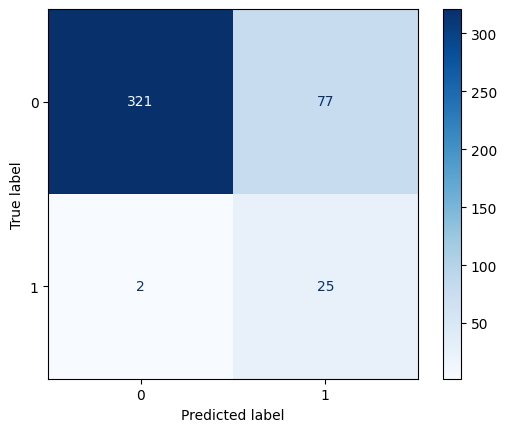

In [ ]:
# final_features = ["Radius"]
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred_lr = lr.predict_proba(X_test_lr)[:, 1] > 0.98
# y_mixed = (best_model.predict_proba(X_test)[:, 1] > 0.54) | (1-bandgap_criteria_test.astype(int))


cm_lr = confusion_matrix(y_test, y_pred_lr)

print("Confusion Matrix (All Features):")
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot(cmap=plt.cm.Blues)
plt.show()


In [45]:
import warnings

# Suppress only the warning about 'use_label_encoder'
warnings.filterwarnings("ignore")


data = pd.read_csv("data/REl data and Cp data joined dec20_gg.csv")

print("Before:", data.shape)

# (B) Preprocess
df_processed = preprocess_dataset(data)  # Inverts label to 1=fail

print("After preprocess:", df_processed.shape)


# (C) Train/Test
train_data, test_data = create_train_test_data(df_processed)

# Optional: Filter features (variance + correlation)
# We'll separate out X, then filter
X_train = train_data.iloc[:, :-1]  # exclude label
y_train = train_data.iloc[:, -1]

# We'll do the same for test set
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

X_test_for_baseline = X_test.copy()

# X_test_for_baseline["WAFER_NO"] = X_test["WAFER_NO"]
# X_test_for_baseline["Band gap criteria"] = X_test["Band gap criteria"]

X_train = X_train["Radius"]
X_test = X_test["Radius"]


Before: (2122, 1236)

     Preprocessing the dataset...
     Preprocessing done!

After preprocess: (2122, 484)

     Creating the training and testing dataset...
Number of features kept after Variance threshold 419


In [250]:

radius_criteria_test = X_test_for_baseline["Radius"] <= 70
sensor_criteria_test = X_test_for_baseline["SensorOffsetHot-Cold"] <= 0.02
bandgap_criteria_test = X_test_for_baseline.apply(lambda row: check_band_gap(row['WAFER_NO'], row['Band gap criteria']), axis=1)

In [46]:
from sklearn.model_selection import GridSearchCV
# final_features=["all Criteria together"]

param_grid = {
    "n_estimators": [30, 50, 100, 200],
    "max_depth": [2, 5],
    "learning_rate": [0.01, 0.1, 0.2],
}

# If 1 is 5% => sum(y) is small
# scale_pos_weight = (# of negative / # of positive) => we do # of 0 / # of 1
n_pos = sum(y_train)
n_neg = len(y_train) - n_pos
scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight=scale_pos_weight,
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=f2_scorer,  # F2 for class=1
    cv=3,
    verbose=1,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [230]:
y_mixed

23      False
835      True
596     False
1481    False
214     False
        ...  
1646    False
966     False
128     False
678     False
1933    False
Length: 425, dtype: bool

Confusion Matrix (All Features):


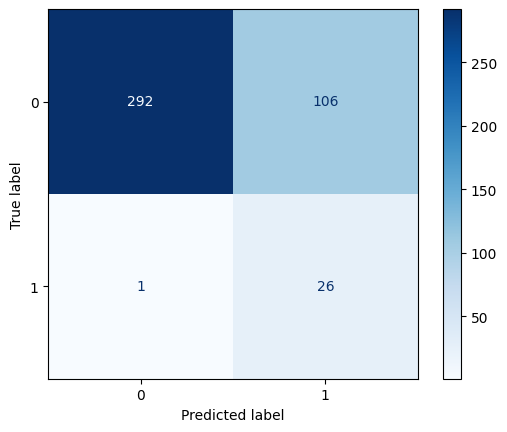

In [56]:
# final_features = ["Radius"]


from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred = best_model.predict_proba(X_test)[:, 1] > 0.51
# y_mixed = (best_model.predict_proba(X_test)[:, 1] > 0.54) | (1-bandgap_criteria_test.astype(int))


cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix (All Features):")
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm)
disp_all.plot(cmap=plt.cm.Blues)
plt.show()


In [76]:
importance_dict = {
    "Features": X.columns,
    "Importance": best_model.feature_importances_,
    "Importance_abs": np.abs(best_model.feature_importances_),
}
importance = pd.DataFrame(importance_dict).sort_values(
    by="Importance", ascending=True
)

,importance,features
200,1,Radius
139,2,Leakage:LEAK_h2@Leakage_1_ of FT3
24,3,Bias_Ref_test:PAR_ID@Bias_Ref_test_1_ of FT1
165,4,Output_Buffer:OBVOH@Output_Buffer_Test_1_ of FT3
167,5,Output_Buffer:OBSHORTH@Output_Buffer_Test_1_ o...
...,...,...
156,201,Bias_Ref_test:GBIASML@Bias_Ref_test_1_ of FT3
155,202,Bias_Ref_test:GBIASMH@Bias_Ref_test_1_ of FT3
128,203,Magnetic_DC_1:V_V0FVBIN_MAG_Tx@Magnetic_DC_1_1...
204,204,band gap dpat_ok for band gap


In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

# --------------------------------------------------------
# 3) Define a Custom F2 Scorer for Class=1
# --------------------------------------------------------
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

# --------------------------------------------------------
# 4) Set up SVC (class_weight='balanced', probability=True)
#    - 'balanced' => automatically inversely proportional to class frequencies
#    - probability=True => we can call .predict_proba() for custom thresholds
# --------------------------------------------------------
svm_clf = SVC(
    kernel='rbf',
    class_weight='balanced',
    probability=True,
    random_state=42
)

# --------------------------------------------------------
# 5) RFECV with SVM + F2 scoring
# --------------------------------------------------------
# rfecv = RFECV(
#     estimator=svm_clf,
#     step=5,
#     cv=5,
#     scoring=f2_scorer,
#     min_features_to_select=1
# )

svm_clf.fit(X_train_scaled, y_train)


SVC(class_weight='balanced', probability=True, random_state=42)

Confusion Matrix (All Features):


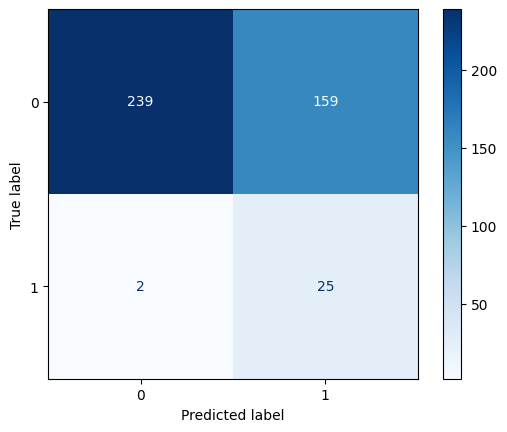

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_all = svm_clf.predict_proba(X_test_scaled)[:, 1] > 0.021

cm_all = confusion_matrix(y_test, y_pred_all)

print("Confusion Matrix (All Features):")
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all)
disp_all.plot(cmap=plt.cm.Blues)
plt.show()

Confusion Matrix (All Features):


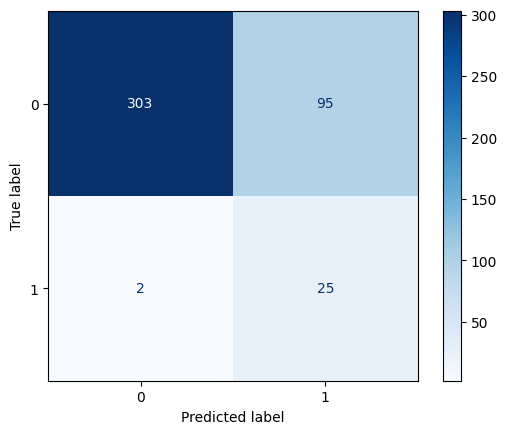

In [63]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_all = model_all_xgb.predict_proba(X_test["Radius"])[:, 1] > 0.02

cm_all = confusion_matrix(y_test, y_pred_all)

print("Confusion Matrix (All Features):")
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all)
disp_all.plot(cmap=plt.cm.Blues)
plt.show()

Before: (2122, 1236)

     Preprocessing the dataset...
     Preprocessing done!

After preprocess: (2122, 484)

     Creating the training and testing dataset...
Number of features kept after Variance threshold 419
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Confusion Matrix - baseline Features:


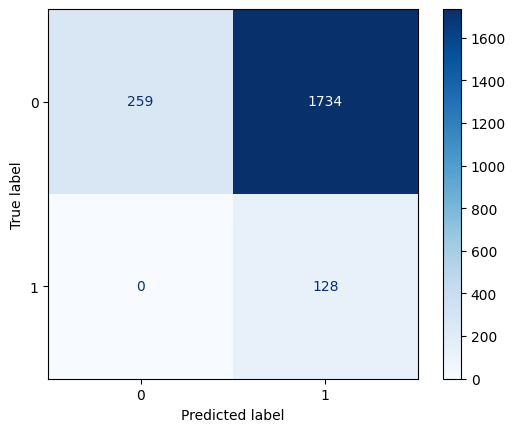

In [416]:
import warnings
from sklearn.model_selection import StratifiedKFold


# Suppress only the warning about 'use_label_encoder'
warnings.filterwarnings("ignore")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


data = pd.read_csv("data/REl data and Cp data joined dec20_gg.csv")

print("Before:", data.shape)

# (B) Preprocess
df_processed = preprocess_dataset(data)  # Inverts label to 1=fail

print("After preprocess:", df_processed.shape)


# (C) Train/Test
train_data, test_data = create_train_test_data(df_processed)


# Optional: Filter features (variance + correlation)
# We'll separate out X, then filter
X_train = train_data.iloc[:, :-1]  # exclude label
y_train = train_data.iloc[:, -1]

# We'll do the same for test set
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

param_grid = {
    "n_estimators": [20, 50, 100, 200, 300],
    "max_depth": [2, 3, 4, 5, 10, None],
    "min_samples_split": [2, 3, 4, 5],
}

class_weight = {
    0: 1,
    1: sum(1 - y),
}
rf_model = RandomForestClassifier(class_weight=class_weight, random_state=42)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring=f2_rare_scorer,  # F2 for class=1
    cv=cv,
    verbose=1,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

y_pred_all = best_model.predict_proba(X)[:, 1] > 0.05
cm_baseline_rf = confusion_matrix(y, y_pred_all)
disp_baseline_rf = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_rf)
disp_baseline_rf.plot(cmap=plt.cm.Blues)
plt.show()

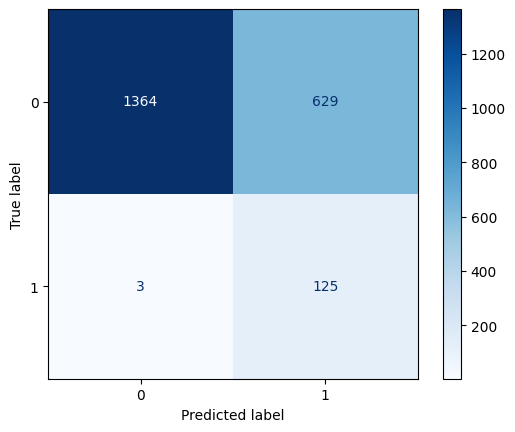

In [419]:
y_pred_all = best_model.predict_proba(X)[:, 1] > 0.4
cm_baseline_rf = confusion_matrix(y, y_pred_all)
disp_baseline_rf = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_rf)
disp_baseline_rf.plot(cmap=plt.cm.Blues)
plt.show()

In [420]:
importance = pd.DataFrame([best_model.feature_importances_, X_train.columns])
# plot
importance = importance.T
importance.columns = ['importance', 'feature']
importance.sort_values(by='importance', inplace=True, ascending=False)
importance.reset_index(drop=True, inplace=True)
importance.set_index('feature', inplace=True)
importance

,importance
feature,
Radius,0.304653
Magnetic_DC:V_VPP8MTFVBI_MAG_Tx@Magnetic_DC_1_ of FT1,0.07406
SensorOffsetHot-Cold-Abs,0.043714
Pin_Tests:PTEN_short@Pin_Tests_1_ of FT2,0.038704
Pin_Tests:CL_short@Pin_Tests_1_ of FT2,0.037573
...,...
Bias_Ref_test:H1BIAS_FIN@Bias_Ref_test_1_ of FT1,0.0
Bias_Ref_test:H2BIAS_FIN@Bias_Ref_test_1_ of FT1,0.0
Magnetic_DC:V_VPPM8MTFVBI_MAG_Tx@Magnetic_DC_1_ of FT1,0.0


## Baseline model and rules

In [40]:
X = data
y = data["Pass/Fail"] == "pass"

radius_criteria = X["Radius"] <= 70
sensor_criteria = X["SensorOffsetHot-Cold"].abs() <= 0.02
bandgap_criteria = data.apply(lambda row: check_band_gap(row['WAFER_NO'], row['Bias_Ref_test:VR1V2D@Bias_Ref_test[1] of FT2']), axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    data, data["Pass/Fail"] == "pass", test_size=0.2, random_state=42
)
radius_criteria_test = X_test["Radius"] <= 70
sensor_criteria_test = X_test["SensorOffsetHot-Cold"] <= 0.02
bandgap_criteria_test = X_test.apply(lambda row: check_band_gap(row['WAFER_NO'], row['Bias_Ref_test:VR1V2D@Bias_Ref_test[1] of FT2']), axis=1)

print(f"Radius criteria: {radius_criteria.sum()}")
print(f"Sensor criteria: {sensor_criteria.sum()}")
print(f"Bandgap criteria: {bandgap_criteria.sum()}")
print(f"Total: {sum(radius_criteria & sensor_criteria & bandgap_criteria)}")

y_pred_baseline = radius_criteria & sensor_criteria & bandgap_criteria
y_pred_baseline_test = radius_criteria_test & sensor_criteria_test & bandgap_criteria_test

In [421]:
import pandas as pd
from scipy.stats import chi2_contingency

def criterion_significance_test(criterion_series, outcome_series, criterion_name="Criterion"):
    """
    Given a boolean Series 'criterion_series' and a boolean Series 'outcome_series',
    compute the chi-square test of independence and return the test result.
    """
    # 1. Create a contingency table
    #    Rows = Criterion True/False, Columns = Outcome Pass/Fail
    contingency_table = pd.crosstab(criterion_series, outcome_series)
    
    # 2. Run chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # 3. Print or return results
    print(f"=== {criterion_name} ===")
    print("Contingency Table:\n", contingency_table)
    print(f"Chi-square statistic = {chi2:.4f}, p-value = {p_value:.4e}, dof = {dof}")
    print("Expected frequencies:\n", expected, "\n")
    
    return chi2, p_value, dof, expected


In [ ]:
chi2_sensor, p_sensor, *_ = criterion_significance_test(
    sensor_criteria, y, criterion_name="SensorOffsetHot-Cold <= 0.02"
)


In [ ]:
chi2_radius, p_radius, *_ = criterion_significance_test(
    radius_criteria, y, criterion_name="Radius <= 70"
)


=== Radius <= 70 ===
Contingency Table:
 Pass/Fail  False  True 
Radius                 
False        125    825
True           4   1168
Chi-square statistic = 148.7178, p-value = 3.3055e-34, dof = 1
Expected frequencies:
 [[  57.75212064  892.24787936]
 [  71.24787936 1100.75212064]] 

=== SensorOffsetHot-Cold <= 0.02 ===
Contingency Table:
 Pass/Fail             False  True 
SensorOffsetHot-Cold              
False                    73    378
True                     56   1615
Chi-square statistic = 100.2330, p-value = 1.3549e-23, dof = 1
Expected frequencies:
 [[  27.41705938  423.58294062]
 [ 101.58294062 1569.41705938]] 



In [42]:
chi2_bandgap, p_bandgap, *_ = criterion_significance_test(
    bandgap_criteria, y, criterion_name="BandGap Criterion"
)


=== BandGap Criterion ===
Contingency Table:
 Pass/Fail  False  True 
row_0                  
False          6     53
True         123   1940
Chi-square statistic = 1.1178, p-value = 2.9040e-01, dof = 1
Expected frequencies:
 [[   3.58671065   55.41328935]
 [ 125.41328935 1937.58671065]] 



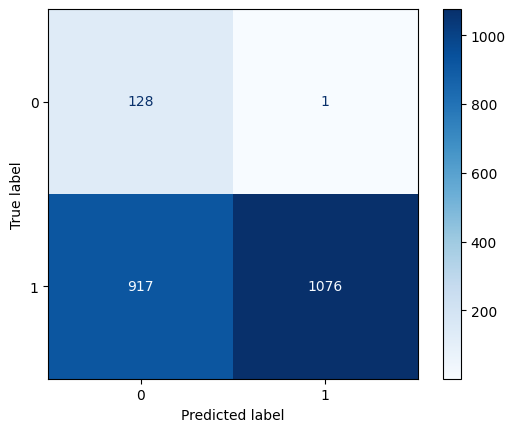

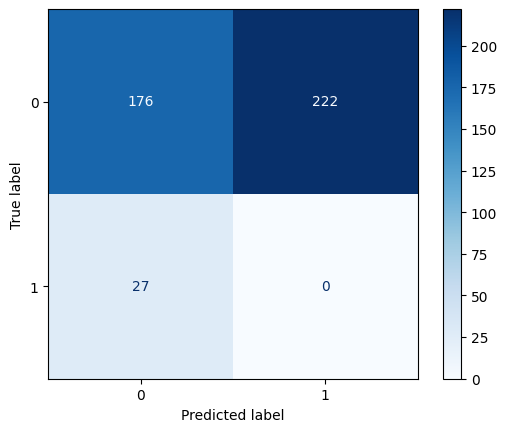

In [44]:
cm_baseline_rf = confusion_matrix(y, y_pred_baseline)
disp_baseline_rf = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_rf)
disp_baseline_rf.plot(cmap=plt.cm.Blues)
plt.show()

cm_baseline_rf_test = confusion_matrix((1-y_test), y_pred_baseline_test)
disp_baseline_rf_test = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_rf_test)
disp_baseline_rf_test.plot(cmap=plt.cm.Blues)
plt.show()

In [190]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression

def run_stratified_kfold_threshold_search(X, y, model, beta=2, n_splits=5, bandgap_criteria=None, sensor_offset=None):
    """
    Performs stratified k-fold cross-validation on (X, y) using the given `model`.
    Searches for the best threshold (0..1) for each fold based on F2 score.
    Returns average metrics and fold-by-fold results.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Containers to track metrics across folds
    best_thresholds = []
    f2_scores = []
    roc_aucs = []
    confusion_matrices = []

    all_preds = []
    all_probs = []
    all_true = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        # -------------------------
        # 1) Split into train/val
        # -------------------------
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val     = X.iloc[val_idx], y.iloc[val_idx]

        # -------------------------
        # 2) Train the model
        # -------------------------
        model.fit(X_train, y_train)

        # -------------------------
        # 3) Predict probabilities
        # -------------------------
        probs_class1 = model.predict_proba(X_val)[:, 1]  # probabilities for class=1
        if bandgap_criteria is not None:
            bandgap_criteria_val = bandgap_criteria[val_idx]
        else:
            bandgap_criteria_val = pd.Series([0]*len(X_val))

        if sensor_offset is not None:
            sensor_offset_val = sensor_offset[val_idx]
        else:
            sensor_offset_val = pd.Series([0]*len(X_val))


        probs_class1[sensor_offset_val] = 1.0
        probs_class1[bandgap_criteria_val] = 1.0

        # -------------------------
        # 4) Find best threshold via F2
        # -------------------------
        thresholds = np.linspace(0, 1, 101)  # 0.00, 0.01, ... 1.00
        best_thr = 0.0
        best_f2 = -1.0
        
        for thr in thresholds:
            y_pred_temp = (probs_class1 >= thr).astype(int)
            f2_temp = fbeta_score(y_val, y_pred_temp, beta=beta, pos_label=1)
            if f2_temp > best_f2:
                best_f2 = f2_temp
                best_thr = thr

        best_thresholds.append(best_thr)

        # Make final predictions at best threshold
        y_pred = (probs_class1 >= best_thr).astype(int)

        # -------------------------
        # 5) Compute & store metrics
        # -------------------------
        f2_scores.append(best_f2)
        roc_aucs.append(roc_auc_score(y_val, probs_class1))

        # Confusion matrix with class=1 as "positive"
        cm = confusion_matrix(y_val, y_pred, labels=[1,0])
        confusion_matrices.append(cm)

        print(f"\nFold {fold_idx+1}: Best threshold={best_thr:.2f}, F2={best_f2:.4f}, ROC AUC={roc_aucs[-1]:.4f}")
        print("Confusion matrix:\n", cm)

        all_preds.extend(y_pred)
        all_probs.extend(probs_class1)
        all_true.extend(y_val)

    # -------------------------
    # 6) Average results
    # -------------------------
    avg_f2 = np.mean(f2_scores)
    avg_roc = np.mean(roc_aucs)

    # Sum of confusion across folds for a "combined" matrix
    sum_confusion = sum(confusion_matrices)

    print("\n======== CROSS-VALIDATION SUMMARY ========")
    print(f"Average best threshold : {np.mean(best_thresholds):.3f}")
    print(f"Average F2 score       : {avg_f2:.4f}")
    print(f"Average ROC AUC        : {avg_roc:.4f}")
    print("Sum of confusion matrices across folds:\n", sum_confusion)

    return {
        "thresholds": best_thresholds,
        "f2_scores": f2_scores,
        "roc_aucs": roc_aucs,
        "avg_f2": avg_f2,
        "avg_roc": avg_roc,
        "sum_confusion": sum_confusion,
        "all_preds": np.array(all_preds),
        "all_probs": np.array(all_probs),
        "all_true": np.array(all_true),
    }

In [422]:
import json

with open("final_features.json", "r") as f:
    final_features_lr = json.load(f)
# final_model_rf = ["Radius", "SensorOffsetHot-Cold", "SensorOffsetHot-Cold-Abs", "Magnetic_DC:V_VPP8MTFVBI_MAG_Tx@Magnetic_DC_1_ of FT1", "Magnetic_DC_after_CAL:V_V0FVBI_MAG2_CAL_Tx@Magnetic_DC_after_CAL_1_ of FT1",  "Leakage:LEAK_h1@Leakage_1_ of FT1", "Output_Buffer:OBVOH@Output_Buffer_Test_1_ of FT1"]

# Example: final dataset is preprocessed_df
preprocessed_df_with_outlier = preprocess_dataset(data)
outlier_mask = (preprocessed_df_with_outlier["Radius"] < 32) & (
    preprocessed_df_with_outlier["Pass/Fail"]
)



# Use ~ to invert it, so we keep rows that are NOT outliers
preprocessed_dataset = preprocessed_df_with_outlier[~outlier_mask].reset_index(drop=True)

bandgap_fail = 1 - preprocessed_dataset["band gap dpat_ok for band gap"]
sensor_offset = preprocessed_dataset[ "SensorOffsetHot-Cold-Abs"] > 0.02


X_full = preprocessed_dataset.iloc[:, :-1]
y_full = preprocessed_dataset.iloc[:,  -1]
X_full = X_full


# Example: logistic regression
num_pos = y_full.sum()
num_neg = len(y_full) - num_pos
# scale_pos_weight = num_neg / num_pos * 10 if num_pos > 0 else 1.0
weights = [1, 10, 25, 50, 75, 99, 100, 1000]

model_xgboost = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    # scale_pos_weight=scale_pos_weight,
    random_state=42
)


param_grid = {
    "n_estimators": [10, 30, 50, 100, 200],
    "max_depth": [2, 3, 4, 5, 10],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "scale_pos_weight" : weights
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=f2_scorer,  # F2 for class=1
    cv=5,
    verbose=1,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)
best_model_xgb = grid_search.best_estimator_
print(best_model_xgb)

results_xgb = run_stratified_kfold_threshold_search(
    X_full, 
    y_full, 
    model=best_model_xgb,
    beta=5,           # F2
    n_splits=20,       # 10-fold CV
    sensor_offset=sensor_offset,
    bandgap_criteria=bandgap_fail
)

print("CV Results:\n", results_xgb)

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

global_cm = confusion_matrix(results_xgb["all_true"], results_xgb["all_preds"], labels=[1,0])
fpr, tpr, _ = roc_curve(results_xgb["all_true"], results_xgb["all_probs"], pos_label=1)
global_auc = roc_auc_score(results_xgb["all_true"], results_xgb["all_probs"])

print("Global confusion matrix:\n", global_cm)
print(f"Global ROC AUC: {global_auc:.4f}, Best threshold: {np.mean(results_xgb["thresholds"])}")




     Preprocessing the dataset...
     Preprocessing done!

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Fold 1: Best threshold=0.56, F2=0.8545, ROC AUC=0.8064
Confusion matrix:
 [[ 7  0]
 [31 69]]

Fold 2: Best threshold=0

In [425]:
grid_search.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'n_estimators': 50,
 'scale_pos_weight': 99}

In [273]:
import json

with open("final_features.json", "r") as f:
    final_features_lr = json.load(f)

# Example: final dataset is preprocessed_df
preprocessed_dataset = preprocess_dataset(data)

outlier_mask = (preprocessed_dataset["Radius"] < 32) & (
    preprocessed_dataset["Pass/Fail"]
)

# Use ~ to invert it, so we keep rows that are NOT outliers
preprocessed_dataset = preprocessed_dataset[~outlier_mask].reset_index(drop=True)

bandgap_fail = 1 - preprocessed_dataset["band gap dpat_ok for band gap"]
sensor_offset = preprocessed_dataset[ "SensorOffsetHot-Cold-Abs"] > 0.02


X_full = preprocessed_dataset.iloc[:, :-1]
y_full = preprocessed_dataset.iloc[:,  -1]
X_full = X_full
# (Optional) feature filtering here or inside each fold
# X_full, final_cols = variance_correlation_filter(X_full, 0.0, 0.99)
# X_full = X_full[final_cols]

# Example: logistic regression
model_logreg = LogisticRegression(
    class_weight={0: 1, 1: sum(1 - y_full)}, 
    max_iter=1000,
    random_state=42
)

results_log = run_stratified_kfold_threshold_search(
    X_full, 
    y_full, 
    model=model_logreg,
    beta=5,          # F2
    n_splits=20,       # 10-fold CV
    # bandgap_criteria=bandgap_fail,
    # sensor_offset=sensor_offset
)

print("CV Results:\n", results_log)

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

global_cm = confusion_matrix(results_log["all_true"], results_log["all_preds"], labels=[1,0])
fpr, tpr, _ = roc_curve(results_log["all_true"], results_log["all_probs"], pos_label=1)
global_auc = roc_auc_score(results_log["all_true"], results_log["all_probs"])

print("Global confusion matrix:\n", global_cm)
print(f"Global ROC AUC: {global_auc:.4f}, Best threshold: {np.mean(results_log["thresholds"]):.4f}")



     Preprocessing the dataset...
     Preprocessing done!


Fold 1: Best threshold=0.99, F2=0.6523, ROC AUC=0.4743
Confusion matrix:
 [[ 7  0]
 [97  3]]

Fold 2: Best threshold=0.00, F2=0.6094, ROC AUC=0.4917
Confusion matrix:
 [[  6   0]
 [100   0]]

Fold 3: Best threshold=0.99, F2=0.6166, ROC AUC=0.4683
Confusion matrix:
 [[ 6  0]
 [97  3]]

Fold 4: Best threshold=0.00, F2=0.6094, ROC AUC=0.3917
Confusion matrix:
 [[  6   0]
 [100   0]]

Fold 5: Best threshold=0.00, F2=0.6094, ROC AUC=0.5867
Confusion matrix:
 [[  6   0]
 [100   0]]

Fold 6: Best threshold=0.00, F2=0.6094, ROC AUC=0.3250
Confusion matrix:
 [[  6   0]
 [100   0]]

Fold 7: Best threshold=0.00, F2=0.6094, ROC AUC=0.4017
Confusion matrix:
 [[  6   0]
 [100   0]]

Fold 8: Best threshold=0.00, F2=0.6094, ROC AUC=0.4683
Confusion matrix:
 [[  6   0]
 [100   0]]

Fold 9: Best threshold=0.99, F2=0.6265, ROC AUC=0.6467
Confusion matrix:
 [[ 6  0]
 [93  7]]

Fold 10: Best threshold=0.00, F2=0.6094, ROC AUC=0.2783
Confusion ma

In [ ]:
import json
import numpy as np
import pandas as pd

from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    fbeta_score,
    make_scorer,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# ============ STEP 1: Load the final features (if needed) ============
with open("final_features.json", "r") as f:
    final_features_if = json.load(f)

# Suppose these are the features you want to use in Isolation Forest
# e.g. final_features_if = ["Radius", "SensorOffsetHot-Cold-Abs", ...]
# Make sure your preprocessed dataframe has these columns.

# Example: final dataset is preprocessed_df
preprocessed_df_with_outlier = preprocess_dataset(data)

# Example outlier mask (same as your snippet, if relevant)
outlier_mask = (preprocessed_df_with_outlier["Radius"] < 32) & (
    preprocessed_df_with_outlier["Pass/Fail"]
)

# Use ~ to invert the mask (keep rows that are NOT outliers, if you wish)
preprocessed_dataset = preprocessed_df_with_outlier[~outlier_mask].reset_index(drop=True)


# ============ STEP 3: Define auxiliary criteria (bandgap, sensor_offset, etc.) ============
# If you still want to track these conditions, keep them as before:
bandgap_fail = 1 - preprocessed_dataset["band gap dpat_ok for band gap"]
sensor_offset = preprocessed_dataset["SensorOffsetHot-Cold-Abs"] > 0.02

# ============ STEP 4: Prepare your X and y ============
# In typical outlier-detection setups:
#   - y = 1 => "Fail" => outlier
#   - y = 0 => "Pass" => inlier
# Adjust the slice for your own dataset accordingly.

# Last column is Pass/Fail in your snippet
X_full = preprocessed_dataset.iloc[:, :-1]
y_full = preprocessed_dataset.iloc[:,  -1]

# Ensure y is 0/1 where 1 = Fail (outlier), 0 = Pass (inlier)
# (If your "Pass/Fail" column is already {True/False}, convert as needed.)
y_full = y_full.astype(int)

print("Number of samples:", len(X_full))
print("Number of fails (outliers):", sum(y_full))
print("Number of passes (inliers):", len(y_full) - sum(y_full))

# ============ STEP 5: Define a custom F-beta scorer for isolation forest ============
# IsolationForest.predict(X) returns +1 for inliers, -1 for outliers.
# We want outliers predicted as 1 if we consider "Fail" = 1.
def isolation_fbeta_scorer(estimator, X, y_true, beta=2.0):
    """
    Custom scoring function to evaluate F-beta (e.g., F2) 
    on the assumption that y_true=1 => outlier, 0 => inlier.
    """
    # Predict with isolation forest
    y_pred_raw = estimator.predict(X)
    # Convert +1 (inlier) => 0,  -1 (outlier) => 1
    y_pred = np.where(y_pred_raw == -1, 1, 0)
    return fbeta_score(y_true, y_pred, beta=beta)

# Make a scorer object suitable for GridSearchCV
f2_scorer_iforest = make_scorer(
    isolation_fbeta_scorer,
    beta=2.0,  # F2
    greater_is_better=True,
    needs_proba=False,
    needs_threshold=False
)

# ============ STEP 6: Define your Isolation Forest and hyperparameter grid ============
model_if = IsolationForest(random_state=42)

param_grid_if = {
    "n_estimators":   [50, 100, 200],
    "max_samples":    ["auto", 0.8, 0.9],
    "contamination":  [0.01, 0.05, 0.1],  # Adjust based on expected % of outliers
    "max_features":   [1.0, 0.5, 0.8],
    "bootstrap":      [False, True],
}

grid_search_if = GridSearchCV(
    estimator=model_if,
    param_grid=param_grid_if,
    scoring=f2_scorer_iforest,
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Since IsolationForest is unsupervised, but we do have known labels,
# we treat "y_full" as if it were a target. GridSearchCV will
# split X, y, train on X_train, then evaluate predictions on X_test
# for scoring. 
grid_search_if.fit(X_full, y_full)
best_model_if = grid_search_if.best_estimator_

print("Best Isolation Forest Model:", best_model_if)
print("Best CV Score (F2):", grid_search_if.best_score_)


# ============ STEP 7: Cross-Validate final model on the entire dataset ============

# Run the cross-validation with the best model
results_if = run_stratified_kfold_threshold_search(    X_full, 
    y_full, 
    model=model_logreg,
    beta=5,          # F2
    n_splits=20,       # 10-fold CV)

# ============ STEP 8: Evaluate results ============

# Confusion matrix
cm_if = confusion_matrix(results_if["all_true"], results_if["all_preds"], labels=[1,0])
print("Isolation Forest global confusion matrix (label order = [1,0]):\n", cm_if)

# ROC curve and AUC (we need pos_label=1 => outlier)
fpr_if, tpr_if, thresholds_if = roc_curve(results_if["all_true"], -results_if["all_scores"], pos_label=1)
# Note: we used negative of the decision_function because 
#       higher scores => inlier, so we invert to treat "outlier" as positive.

auc_if = roc_auc_score(results_if["all_true"], -results_if["all_scores"])
print(f"Isolation Forest ROC AUC: {auc_if:.4f}")

# F2 score on combined predictions:
f2_if = fbeta_score(results_if["all_true"], results_if["all_preds"], beta=2)
print(f"Combined F2 score across folds: {f2_if:.4f}")



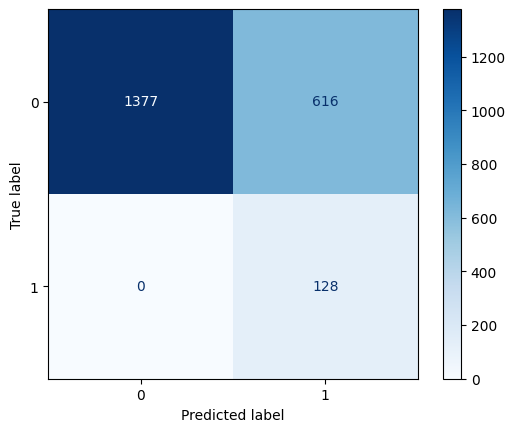

In [447]:
best_model_xgb.fit(X_train, y_train)
y_pred = (best_model_xgb.predict_proba(X)[:, 1]>0.5) #| sensor_offset | bandgap_fail

cm_baseline_rf_test = confusion_matrix(y, y_pred)

disp_baseline_rf_test = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_rf_test)

disp_baseline_rf_test.plot(cmap=plt.cm.Blues)
plt.show()

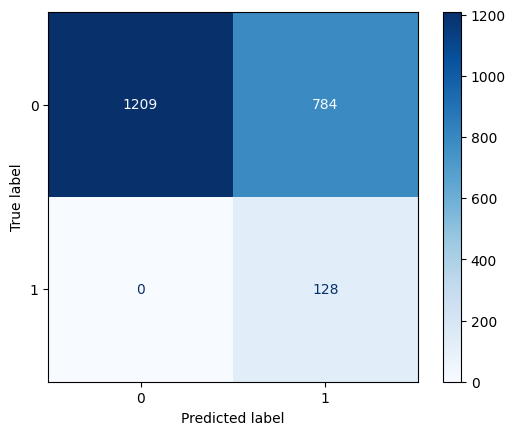

In [202]:
model_logreg.fit(X_full, y_full)
y_pred = (model_logreg.predict_proba(X_full)[:, 1]>0.9) # | sensor_offset | bandgap_fail

cm_baseline_rf_test = confusion_matrix(y_full, y_pred)

disp_baseline_rf_test = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_rf_test)

disp_baseline_rf_test.plot(cmap=plt.cm.Blues)
plt.show()

0.9684999999999999


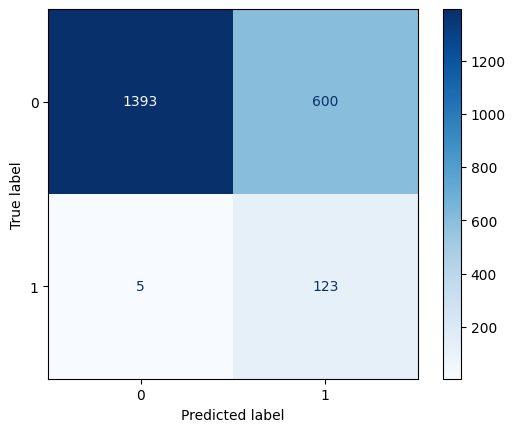

In [263]:
print(np.mean(results_log["thresholds"]))
y_pred = (results_log["all_probs"]>np.mean(results_log["thresholds"])) #| bandgap_fail | sensor_offset
y_true = results_log["all_true"]

cm_baseline_log = confusion_matrix(y_true, y_pred)

disp_baseline_log = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_log)

disp_baseline_log.plot(cmap=plt.cm.Blues)
plt.show()

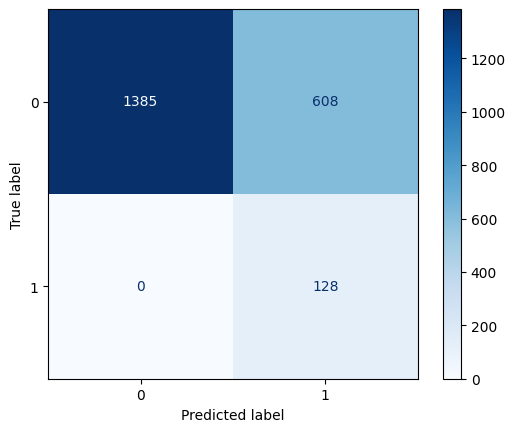

In [271]:
best_model_xgb.fit(X_full, y_full)
y_pred = (best_model_xgb.predict_proba(X_full)[:, 1]>0.2)

cm_baseline_rf_test = confusion_matrix(y_full, y_pred)

disp_baseline_rf_test = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_rf_test)

disp_baseline_rf_test.plot(cmap=plt.cm.Blues)
plt.show()

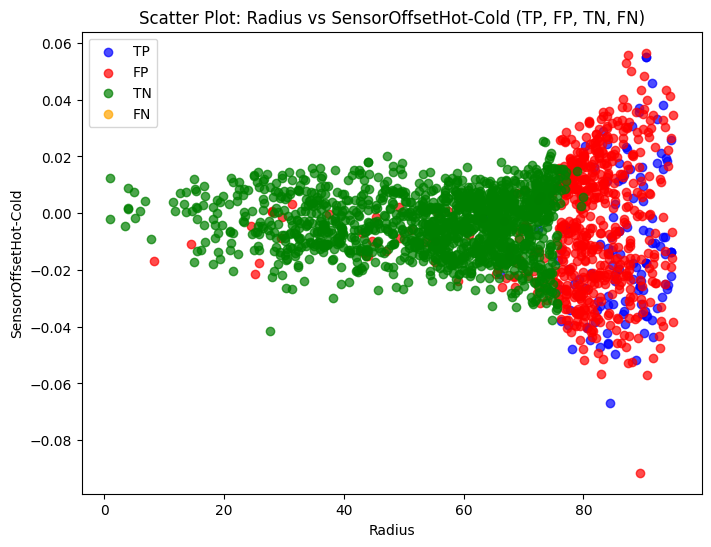

In [272]:
import matplotlib.pyplot as plt

# 1) Copy X_full so we can add columns without altering your original
df_vis = X_full.copy()

# 2) Add the true & predicted labels
df_vis["y_true"] = y_full
df_vis["y_pred"] = y_pred

# 3) Define a function to label each row as TP/FP/TN/FN
def confusion_label(row):
    if row["y_true"] == 1 and row["y_pred"] == 1:
        return "TP"
    elif row["y_true"] == 0 and row["y_pred"] == 0:
        return "TN"
    elif row["y_true"] == 0 and row["y_pred"] == 1:
        return "FP"
    else:  # row["y_true"] == 1 and row["y_pred"] == 0
        return "FN"

df_vis["conf_label"] = df_vis.apply(confusion_label, axis=1)

# 4) Map each confusion label to a color
color_map = {
    "TP": "blue",
    "FP": "red",
    "TN": "green",
    "FN": "orange",
}

# 5) Scatter plot
plt.figure(figsize=(8,6))

for label, color in color_map.items():
    subset = df_vis[df_vis["conf_label"] == label]
    plt.scatter(
        subset["Radius"], 
        subset["SensorOffsetHot-Cold"], 
        c=color, 
        label=label, 
        alpha=0.7,
    )

plt.xlabel("Radius")
plt.ylabel("SensorOffsetHot-Cold")
plt.title("Scatter Plot: Radius vs SensorOffsetHot-Cold (TP, FP, TN, FN)")
plt.legend()
plt.show()


0.5465000000000001


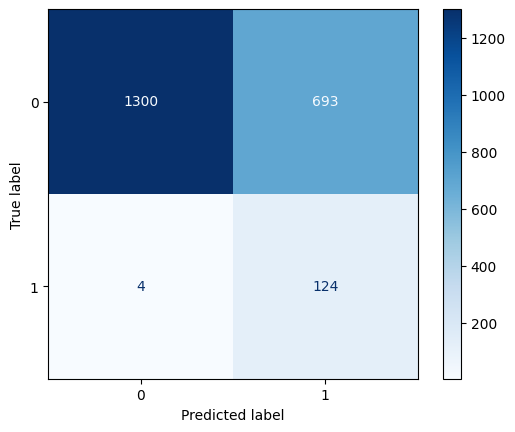

In [251]:
print(np.mean(results_xgb["thresholds"]))
y_pred = (results_xgb["all_probs"]>0.2)
y_true = results_xgb["all_true"]

cm_baseline_rf_test = confusion_matrix(y_true, y_pred)

disp_baseline_rf_test = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_rf_test)

disp_baseline_rf_test.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
import json

with open("final_features.json", "r") as f:
    final_features_lr = json.load(f)

# Example: final dataset is preprocessed_df
preprocessed_dataset = preprocess_dataset(data)

outlier_mask = (preprocessed_dataset["Radius"] < 32) & (
    preprocessed_dataset["Pass/Fail"]
)

# Use ~ to invert it, so we keep rows that are NOT outliers
preprocessed_dataset = preprocessed_dataset[~outlier_mask].reset_index(drop=True)
outlier = preprocessed_dataset[outlier_mask].reset_index(drop=True)

bandgap_fail = 1 - preprocessed_dataset["band gap dpat_ok for band gap"]
sensor_offset = preprocessed_dataset[ "SensorOffsetHot-Cold-Abs"] > 0.02



X_full = preprocessed_dataset.iloc[:, :-1]
y_full = preprocessed_dataset.iloc[:,  -1]
X_full = X_full[final_features_lr]

X_outlier = outlier.iloc[:, :-1]
X_outlier = X_outlier[final_features_lr]

# (Optional) feature filtering here or inside each fold
# X_full, final_cols = variance_correlation_filter(X_full, 0.0, 0.99)
# X_full = X_full[final_cols]

# Example: logistic regression
model_logreg = LogisticRegression(
    class_weight={0: 1, 1: sum(1 - y_full)}, 
    max_iter=1000,
    random_state=42
)
model_logreg.fit(X_full, y_full)
model_logreg.predict_proba(X_outlier)[:, 1]



     Preprocessing the dataset...
     Preprocessing done!



array([0.00361162])

In [234]:
import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, fbeta_score
)
from sklearn.model_selection import train_test_split

# ----------------------------------------------------------------
# 1) Read Data
# ----------------------------------------------------------------
data = pd.read_csv("data/REl data and Cp data joined dec20_gg.csv")
print("Data shape:", data.shape)

# (Optional) If you have a custom preprocessing function:
df_processed = preprocess_dataset(data)

# Make sure 'V_V0_SA_MAG_CAL_DIFF of PostStress' is present in df_processed,
# or copy it over if needed.
df_processed["V_V0_SA_MAG_CAL_DIFF of PostStress"] = data["V_V0_SA_MAG_CAL_DIFF of PostStress"]

# Now we have columns: 
#    - 'Pass/Fail' (0=pass, 1=fail)  [from your code]
#    - 'V_V0_SA_MAG_CAL_DIFF of PostStress' (numeric target)
#    - plus other feature columns to use for regression

# ----------------------------------------------------------------
# 2) Separate Features, Targets
# ----------------------------------------------------------------
# Let y_reg = numeric column the regressor will predict
y_reg = df_processed["V_V0_SA_MAG_CAL_DIFF of PostStress"]

# Let y_clf = actual pass/fail label (for final comparison)
y_clf = df_processed["Pass/Fail"]

# X = all remaining columns EXCEPT 'V_V0_SA_MAG_CAL_DIFF of PostStress' & 'Pass/Fail'
X = df_processed.drop(["V_V0_SA_MAG_CAL_DIFF of PostStress", "Pass/Fail"], axis=1, errors='ignore')

X = X[final_features_lr]
# ----------------------------------------------------------------
# 3) Train/Test Split
# ----------------------------------------------------------------
# We want to keep the numeric target and the pass/fail label for final evaluation,
# so we do a "multi-output" split or we do it in two steps.
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42
)

print("Shapes => X_train:", X_train.shape, "y_reg_train:", y_reg_train.shape, "y_clf_train:", y_clf_train.shape)

# ----------------------------------------------------------------
# 4) Train Regressor
# ----------------------------------------------------------------
xgb_reg = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)
xgb_reg.fit(X_train, y_reg_train)

print("\nXGBRegressor training complete!\n")

# ----------------------------------------------------------------
# 5) Predict Continuous Values
# ----------------------------------------------------------------
y_pred_reg = xgb_reg.predict(X_test)  # shape=(n_test_samples,)

# ----------------------------------------------------------------
# 6) Convert Predictions => Pass/Fail
# ----------------------------------------------------------------
# Your rule:
#   If predicted < 2.48 or predicted > 2.52 => fail=1
#   Otherwise => pass=0
#
y_pred_class = np.where((y_pred_reg < 2.495) | (y_pred_reg > 2.505), 1, 0)

# ----------------------------------------------------------------
# 7) Evaluate vs. True Pass/Fail
# ----------------------------------------------------------------
# Confusion Matrix => with labels=[1,0] ensures row=fail, row=pass
cm = confusion_matrix(y_clf_test, y_pred_class, labels=[1, 0])
print("Confusion Matrix (labels=[1, 0]):\n", cm)

# Classification Report => includes precision, recall, F1
report = classification_report(y_clf_test, y_pred_class, labels=[1, 0])
print("\nClassification Report:\n", report)

# Accuracy
accuracy = accuracy_score(y_clf_test, y_pred_class)
print("Accuracy:", round(accuracy, 3))

# Example: F2 Score (pos_label=1 => fail)
f2_score = fbeta_score(y_clf_test, y_pred_class, beta=2, pos_label=1)
print("F2 score (fail=1):", round(f2_score, 3))

# If you need recall & precision separately:
# We can parse them from classification_report or compute directly:
# from sklearn.metrics import precision_score, recall_score
# precision = precision_score(y_clf_test, y_pred_class, pos_label=1)
# recall = recall_score(y_clf_test, y_pred_class, pos_label=1)


Data shape: (2122, 1236)

     Preprocessing the dataset...
     Preprocessing done!

Shapes => X_train: (1697, 25) y_reg_train: (1697,) y_clf_train: (1697,)

XGBRegressor training complete!

Confusion Matrix (labels=[1, 0]):
 [[ 19   8]
 [218 180]]

Classification Report:
               precision    recall  f1-score   support

           1       0.08      0.70      0.14        27
           0       0.96      0.45      0.61       398

    accuracy                           0.47       425
   macro avg       0.52      0.58      0.38       425
weighted avg       0.90      0.47      0.58       425

Accuracy: 0.468
F2 score (fail=1): 0.275


In [307]:
X_full.to_numpy(dtype=np.float32).shape

(2121, 483)

num_pos=102, num_neg=1594, pos_weight=15627.45
Epoch [1/10] - Loss: 31.9011
Epoch [2/10] - Loss: 1.2021
Epoch [3/10] - Loss: 1.2047
Epoch [4/10] - Loss: 1.0392
Epoch [5/10] - Loss: 0.9780
Epoch [6/10] - Loss: 1.0626
Epoch [7/10] - Loss: 0.9930
Epoch [8/10] - Loss: 1.0279
Epoch [9/10] - Loss: 0.8505
Epoch [10/10] - Loss: 0.6231

Confusion Matrix (labels=[0,1])
 [[188 211]
 [  2  24]]

Classification Report (pos_label=1):
               precision    recall  f1-score   support

           1       0.10      0.92      0.18        26
           0       0.99      0.47      0.64       399

    accuracy                           0.50       425
   macro avg       0.55      0.70      0.41       425
weighted avg       0.94      0.50      0.61       425



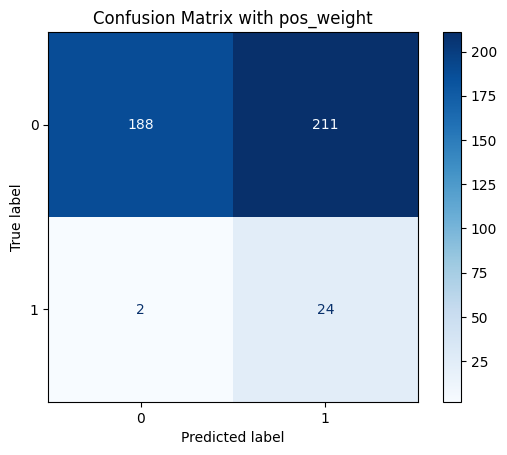

In [381]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# Synthetic data or your real data
np.random.seed(42)
torch.manual_seed(42)

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_full)

X = X_scaled.astype(dtype=np.float32)
y = y_full.to_numpy(dtype=np.float32)

n_features = X.shape[1]

# --------------------------------------------------
# 1) Split into Train/Test
# --------------------------------------------------
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to Torch tensors
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np).view(-1, 1)

X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# --------------------------------------------------
# 2) Compute pos_weight (neg/pos ratio or your choice)
# --------------------------------------------------
num_pos = (y_train_np == 1).sum()
num_neg = (y_train_np == 0).sum()

# Common choice => ratio = num_neg / num_pos
ratio = float(num_neg) / float(num_pos) * 1000
pos_weight_tensor = torch.tensor([ratio], dtype=torch.float32)

print(f"num_pos={num_pos}, num_neg={num_neg}, pos_weight={pos_weight_tensor.item():.2f}")

# --------------------------------------------------
# 3) Define the Model (output = logits, no final sigmoid)
# --------------------------------------------------
class AnomalyDetector(nn.Module):
    def __init__(self, input_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 32)

        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 4)
        self.fc5 = nn.Linear(4, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.dropout(x, p=0.2)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x

model = AnomalyDetector(input_dim=n_features)

# --------------------------------------------------
# 4) Loss & Optimizer (use BCEWithLogits + pos_weight)
# --------------------------------------------------
# You can use the functional API or the nn.Module version
# We'll show nn.Module for clarity
optimizer = optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
scheduler = optim.lr_scheduler.ExponentialLR(gamma=0.99, optimizer=optimizer)

# --------------------------------------------------
# 5) Train the Model
# --------------------------------------------------
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        logits = model(batch_x)                        # shape=[batch_size,1]
        # print(logits)

        loss = criterion(logits, batch_y)    

        # mask = ((batch_y != 0) | (torch.rand_like(batch_y)<0.1)).float()
        # target_w = batch_y.clone()
        # target_w[batch_y==1] = ratio
        # target_w[batch_y==0] = 0.1
        # weight = target_w * mask

        # loss = nn.functional.binary_cross_entropy_with_logits(input=logits, target=batch_y, reduction='none', weight=weight) 
        # loss = loss * mask
        # print(loss)

        # loss = loss.sum() / mask.sum()
        # loss = criterion(logits, batch_y)              # BCEWithLogitsLoss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

# --------------------------------------------------
# 6) Evaluate on Test Set
# --------------------------------------------------
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        logits = model(batch_x)                       # raw logits
        probs = torch.sigmoid(logits)                 # convert to probabilities
        preds = (probs >= 0.5).float()                # threshold
        all_preds.extend(preds.squeeze().cpu().numpy())
        all_labels.extend(batch_y.squeeze().cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

cm = confusion_matrix(all_labels, all_preds, labels=[0,1])
print("\nConfusion Matrix (labels=[0,1])\n", cm)
print("\nClassification Report (pos_label=1):\n", 
      classification_report(all_labels, all_preds, labels=[1,0]))

disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp_nn.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix with pos_weight")
plt.show()


Training set has shape: (1594, 483) (only normal data)
Epoch [1/100], Loss: 0.6837
Epoch [2/100], Loss: 0.5732
Epoch [3/100], Loss: 0.5379
Epoch [4/100], Loss: 0.5224
Epoch [5/100], Loss: 0.5169
Epoch [6/100], Loss: 0.5040
Epoch [7/100], Loss: 0.4962
Epoch [8/100], Loss: 0.4922
Epoch [9/100], Loss: 0.4937
Epoch [10/100], Loss: 0.4880
Epoch [11/100], Loss: 0.4887
Epoch [12/100], Loss: 0.4829
Epoch [13/100], Loss: 0.4869
Epoch [14/100], Loss: 0.4826
Epoch [15/100], Loss: 0.4777
Epoch [16/100], Loss: 0.4815
Epoch [17/100], Loss: 0.4748
Epoch [18/100], Loss: 0.4779
Epoch [19/100], Loss: 0.4793
Epoch [20/100], Loss: 0.4788
Epoch [21/100], Loss: 0.4820
Epoch [22/100], Loss: 0.4732
Epoch [23/100], Loss: 0.4713
Epoch [24/100], Loss: 0.4739
Epoch [25/100], Loss: 0.4763
Epoch [26/100], Loss: 0.4700
Epoch [27/100], Loss: 0.4736
Epoch [28/100], Loss: 0.4692
Epoch [29/100], Loss: 0.4712
Epoch [30/100], Loss: 0.4676
Epoch [31/100], Loss: 0.4633
Epoch [32/100], Loss: 0.4695
Epoch [33/100], Loss: 0.46

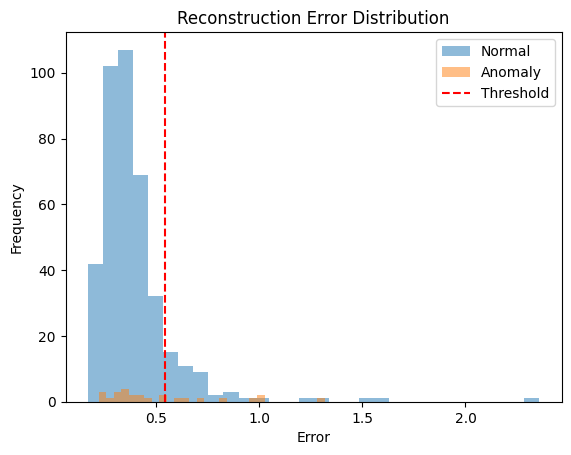

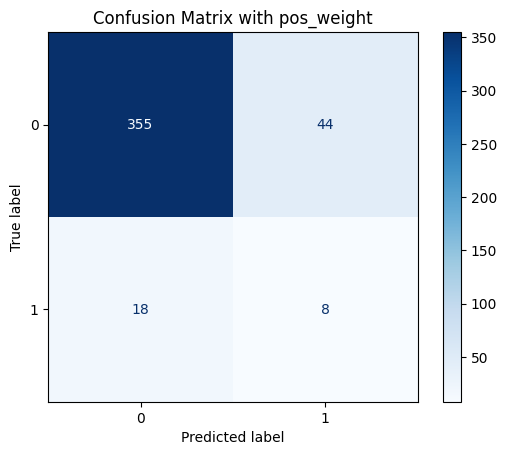

In [389]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# -------------------------------------
# A) Synthetic or Real Dataset
# -------------------------------------
# Assume you have X (features) and y (labels in {0,1}), shape of X => (n_samples, n_features)

# For demonstration, let's create a synthetic dataset:
np.random.seed(42)
torch.manual_seed(42)

# n_samples = 2000
# n_features = 10

# # 1) Generate random normal data for "normal" (label=0):
# X_normal = np.random.normal(loc=0.0, scale=1.0, size=(1800, n_features)).astype(np.float32)
# y_normal = np.zeros(1800, dtype=np.float32)

# # 2) Generate random data for "anomalous" (label=1):
# X_anomaly = np.random.normal(loc=5.0, scale=1.0, size=(200, n_features)).astype(np.float32)
# y_anomaly = np.ones(200, dtype=np.float32)

# # Combine
# X_all = np.vstack([X_normal, X_anomaly])
# y_all = np.concatenate([y_normal, y_anomaly])

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_full)

X_all = X_scaled.astype(dtype=np.float32)
y_all = y_full.to_numpy(dtype=np.float32)

n_features = X.shape[1]


# Train/test split (stratify on y to keep ratio)
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# -------------------------------------
# B) Filter out only normal data (label=0) for training AE
# -------------------------------------
normal_mask = (y_train_np == 0)
X_train_normal = X_train_np[normal_mask]  # shape => (# of normal samples, n_features)

print("Training set has shape:", X_train_normal.shape, "(only normal data)")

# Convert to tensors
X_train_tensor = torch.from_numpy(X_train_normal)
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Test set (includes normal & anomaly)
X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np)

# -------------------------------------
# C) Define a Simple Autoencoder
# -------------------------------------
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=483, latent_dim=32):
        super(AutoEncoder, self).__init__()
        
        # ENCODER
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Dropout(0.2),          # optional dropout

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),

            nn.Linear(128, latent_dim)  # final latent representation
        )

        # DECODER (mirror-like structure)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Dropout(0.2),

            nn.Linear(256, input_dim)   # no activation => real-valued reconstruction
        )

    def forward(self, x):
        # x shape: [batch_size, 483]
        z = self.encoder(x)         # shape: [batch_size, latent_dim]
        out = self.decoder(z)       # shape: [batch_size, 483]
        return out

model = AutoEncoder(input_dim=n_features, latent_dim=8)

# -------------------------------------
# D) Train the Autoencoder
# -------------------------------------
criterion = nn.MSELoss()  # reconstruction error
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for (batch_x,) in train_loader:  # single tuple (batch_x,) from TensorDataset
        # Forward
        batch_x = batch_x.float()  # ensure float
        reconstructed = model(batch_x)
        loss = criterion(reconstructed, batch_x)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(batch_x)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# -------------------------------------
# E) Evaluate on Test (Normal + Anomaly)
# -------------------------------------
model.eval()
with torch.no_grad():
    # Convert to float
    X_test_tensor_f = X_test_tensor.float()
    reconstructed_test = model(X_test_tensor_f)
    # Compute reconstruction error
    errors = torch.mean((reconstructed_test - X_test_tensor_f)**2, dim=1).cpu().numpy()

# We have `errors` for every sample in the test set (y_test_np)

# -------------------------------------
# F) Choose a Threshold & Predict Anomaly
# -------------------------------------
# 1) One simple approach: pick threshold as, e.g., 95th percentile of reconstruction error on training normal data
#    or use some domain knowledge. For demonstration, we'll just pick a percentile of the test set "normal" portion, or 
#    we can do a simpler approach and guess.

# Let's do a quick approach: 
#   We'll get the reconstruction errors of the train normal set and pick percentile=95
model.eval()
with torch.no_grad():
    train_recon = model(torch.from_numpy(X_train_normal).float())
    train_errors = torch.mean((train_recon - torch.from_numpy(X_train_normal).float())**2, dim=1).numpy()

threshold = np.percentile(train_errors, 95)  # e.g., 95th percentile
print(f"Chosen anomaly threshold: {threshold:.4f}")

# 2) Predict anomaly if error > threshold
y_pred_anomaly = (errors > threshold).astype(np.float32)  # 1=anomaly, 0=normal

# -------------------------------------
# G) Confusion Matrix & Metrics
# -------------------------------------
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test_np, y_pred_anomaly, labels=[0,1])
print("\nConfusion Matrix (labels=[0,1]):\n", cm)
print("\nClassification Report (pos_label=1):\n",
      classification_report(y_test_np, y_pred_anomaly, labels=[1,0]))

# Optional: visualization of reconstruction error
plt.hist(errors[y_test_np==0], bins=30, alpha=0.5, label="Normal")
plt.hist(errors[y_test_np==1], bins=30, alpha=0.5, label="Anomaly")
plt.axvline(x=threshold, color="red", linestyle="--", label="Threshold")
plt.title("Reconstruction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp_nn.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix with pos_weight")
plt.show()


In [ ]:
X_full

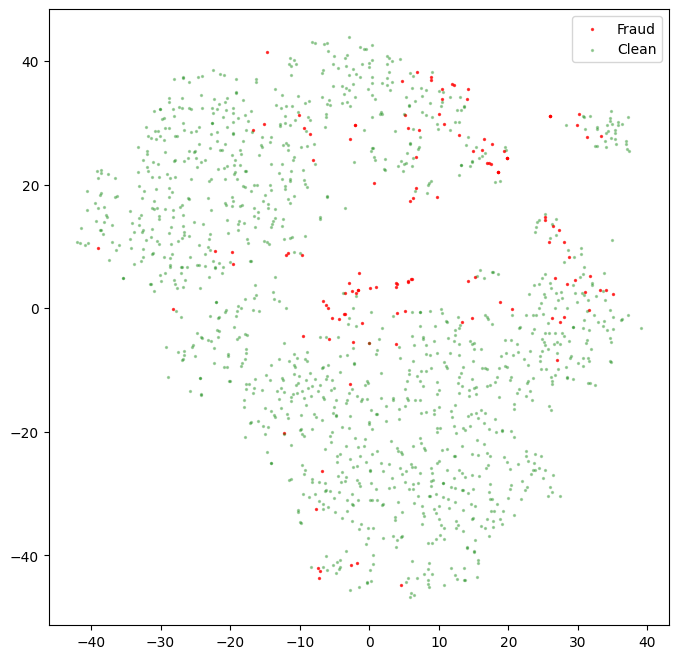

In [403]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=42).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))
    
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

X_scaled = pd.DataFrame(scaler.fit_transform(X_full[final_features_lr]))

RATIO_TO_FRAUD = 10
# splitting by class
fraud = X_scaled[y_full == 1]
clean = X_scaled[y_full == 0]

# undersample clean transactions
clean_undersampled = clean.sample(
    int(len(fraud) * RATIO_TO_FRAUD),
    random_state=42
)

y_fraud = y_full[y_full == 1]
y_clean = y_full[y_full == 0]

# undersample clean transactions
y_clean_undersampled = y_clean.sample(
    int(len(y_fraud) * RATIO_TO_FRAUD),
    random_state=42
)

# concatenate with fraud transactions into a single dataframe
X_undersampled = pd.concat([fraud, clean_undersampled])
y_undersampled = pd.concat([y_fraud, y_clean_undersampled])


tsne_scatter(X_undersampled, y_undersampled, dimensions=2, save_as='tsne_initial_2d_under.png')


In [318]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
import numpy as np

# Simple synthetic data: 1000 samples, 2 features
# Label=1 if x1 + x2 > 0, else 0 (just a line)
np.random.seed(42)
X = X_full.to_numpy(dtype=np.float32)
y = y_full.to_numpy(dtype=np.float32)

X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(y).view(-1,1)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(483, 8)
        self.fc2 = nn.Linear(8, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        # final => Sigmoid
        x = torch.sigmoid(self.fc2(x))
        return x

model = Net()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(200):
    total_loss = 0.0
    for bx, by in loader:
        out = model(bx)
        loss = criterion(out, by)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * bx.size(0)
    print(f"Epoch {epoch+1} Loss={total_loss/len(dataset):.4f}")

# Evaluate quickly
with torch.no_grad():
    out = model(X_tensor)
    preds = (out >= 0.5).float().view(-1)
    acc = (preds == y_tensor.view(-1)).float().mean()
    print("Accuracy:", acc.item())


Epoch 1 Loss=93.9651
Epoch 2 Loss=93.9651
Epoch 3 Loss=93.9651
Epoch 4 Loss=93.9651
Epoch 5 Loss=93.9651
Epoch 6 Loss=93.9651
Epoch 7 Loss=93.9651
Epoch 8 Loss=93.9651
Epoch 9 Loss=93.9651
Epoch 10 Loss=93.9651
Epoch 11 Loss=93.9651
Epoch 12 Loss=93.9651
Epoch 13 Loss=93.9651
Epoch 14 Loss=93.9651
Epoch 15 Loss=93.9651
Epoch 16 Loss=93.9651
Epoch 17 Loss=93.9651
Epoch 18 Loss=93.9651
Epoch 19 Loss=93.9651
Epoch 20 Loss=93.9651
Epoch 21 Loss=93.9651
Epoch 22 Loss=93.9651
Epoch 23 Loss=93.9651
Epoch 24 Loss=93.9651
Epoch 25 Loss=93.9651
Epoch 26 Loss=93.9651
Epoch 27 Loss=93.9651
Epoch 28 Loss=93.9651
Epoch 29 Loss=93.9651
Epoch 30 Loss=93.9651
Epoch 31 Loss=93.9651
Epoch 32 Loss=93.9651
Epoch 33 Loss=93.9651
Epoch 34 Loss=93.9651
Epoch 35 Loss=93.9651
Epoch 36 Loss=93.9651
Epoch 37 Loss=93.9651
Epoch 38 Loss=93.9651
Epoch 39 Loss=93.9651
Epoch 40 Loss=93.9651
Epoch 41 Loss=93.9651
Epoch 42 Loss=93.9651
Epoch 43 Loss=93.9651
Epoch 44 Loss=93.9651
Epoch 45 Loss=93.9651
Epoch 46 Loss=93.96